# Audio Recoginition 4C16/5C16 Project

## Audio Content & Gender Classification

#### About the dataset

The dataset consists of 25k audio tracks. Each of the audio track records the waveform of an audio recording of a human reading out digit (ie. from 0-9). Your task is to train two classification neural networks that **identify the digit** that has been uttered and **identify the gender**.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *input.npy*
    - *gender.npy*
    - *digit.npy*

The *input.npy* has a shape of (25000, 8000) which indicates 25000 waveforms and 8000 samples from each waveform. Each waveform is normalised with 1 second duration and 8 kHz sampling frequnecy. The *gender.npy* and *digit.npy* files contains the correspondent target information of the 25000 waveforms in the same order.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/4c16-labs/code/lab-07/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/4c16-labs/code/lab-07/'
/content


In [ ]:
# Download the dataset
!curl --create-dirs -o C:/Users/lic9/Desktop/pynb/data/audiowavform-dataset.tar.xz https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiowavform-dataset.tar.xz
# Extract the dataset
!mkdir C:/Users/lic9/Desktop/pynb/data/audiowavform
!tar -xvf C:/Users/lic9/Desktop/pynb/data/audiowavform-dataset.tar.xz -C C:/Users/lic9/Desktop/pynb/data/audiowavform

# Dataset location: /home/tcd/data/audiowavform/public

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  108M   10 11.0M    0     0  20.3M      0  0:00:05 --:--:--  0:00:05 20.3M
 37  108M   37 40.2M    0     0  26.1M      0  0:00:04  0:00:01  0:00:03 26.1M
 66  108M   66 72.0M    0     0  28.3M      0  0:00:03  0:00:02  0:00:01 28.3M
 95  108M   95  103M    0     0  29.1M      0  0:00:03  0:00:03 --:--:-- 29.1M
100  108M  100  108M    0     0  28.3M      0  0:00:03  0:00:03 --:--:-- 28.3M
The syntax of the command is incorrect.


In [2]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize

import tensorflow as tf



from IPython.display import clear_output

from matplotlib.ticker import MaxNLocator

import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [13]:
import tensorflow as tf
tf.

In [3]:
# loading the datasets in memory

dataset_path = 'C:/Users/lic9/Desktop/pynb/data/audiowavform/public'

# xtrain  : numpy array of size n x 8000 which contains the waveforms for each of the 25k audio files.
x = np.load(f'{dataset_path}/xtrain.npy')

# y_num   : numpy array of size n x 10 which contains the digits (as one-hot encoding of the 10 categories) for each of the 25k audio files.
y_num = np.argmax(np.load(f'{dataset_path}/ytrain_num.npy'), axis=-1)

# y_gender: numpy array of size n x 2 which contains the gender (as one-hot encoding of the 2 categories) for each of the 25k audio files.
y_gender = np.argmax(np.load(f'{dataset_path}/ytrain_gender.npy'), axis=-1)


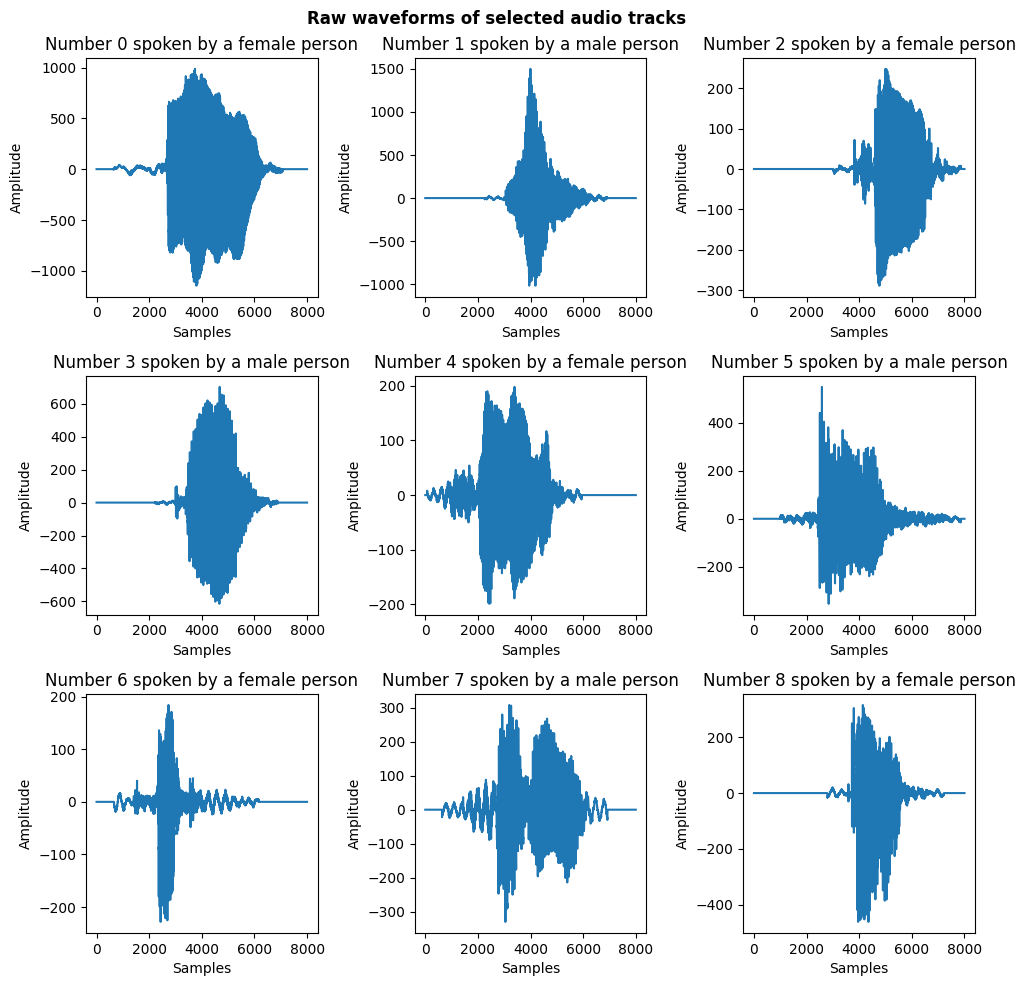

In [4]:
# let's look at the data.
# The code below takes the same samples for the 0-9 digits by females and males
# and display the waveforms asscociated with each of the selected audio files.


gender_ = 0
fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs1.ravel()):
    # we want to show some variety in the genders, so we are alternating genders
    # and seeking the next sample with correct gender/digit
    gender_ = 1 - gender_
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

    # extracting the waveform and the labels
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    # plotting
    ax.plot(
        list(range(1, 8000 + 1, 1)),
        audio_track,
    )
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples')
    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

fig1.suptitle(
    'Raw waveforms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig1.tight_layout(pad=1)

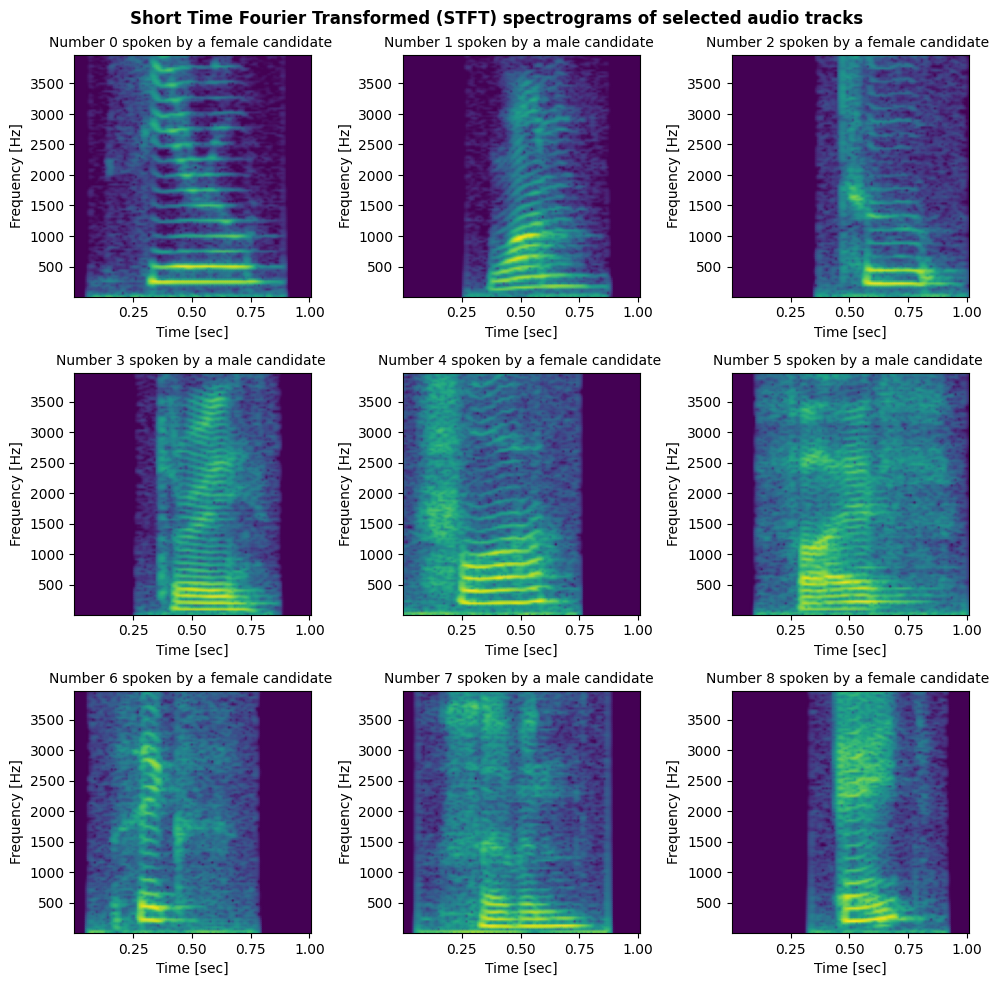

In [5]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # we want to show different genders in this preview, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'
    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when you try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

In [8]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

### The problem

You have two tasks:

1. Train two neural nets taking in _raw waveforms_ and predicting either the digit or the gender. The input waveform should be treated as an 1-dimentional-list with a shape of (8000, 1). Individual models should be trained for each task listed below:

  - Task 1A. **Classification of Gender**: the output is a keras catergorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 1B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

2. Train the neural nets, this time taking the spectrograms as an input. This preprocessing step is commonly considered as a good embedding for representing the audio signal. The spectrograms should be standardised (through cropping) with a shape of [128, 128, 1] (see visualisation sample code above).

  - Task 2A. **Classification of Gender**: the output is a keras categorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 2B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

---

**IMPORTANT**

For Task 1A, your model should be saved and submitted with the name: **'waveform_gender_model'**

For Task 1B, your model should be saved and submitted with the name: **'waveform_digit_model'**

For Task 2A, your model should be saved and submitted with the name: **'spectrogram_gender_model'**

For Task 2B, your model should be saved and submitted with the name: **'spectrogram_digit_model'**


In [ ]:
# Hints:
#
# Keep track of the shape of your datasets.
#   For Task 1, inputs should be a collection of waveforms of size [25000 x 8000 x 1].
#   For Task 2, inputs should be a collection of spectrograms transformed from the loaded
#               waveforms, with size of [25000 x 128 x 128 x 1].
#
#   For both classificaition tasks, output should be a collection of lists of binary number,
#               with size of [25000 x n_classes x 1].
#
#     * For spectrogram classification tasks, refer to the sample code in
#           this jupyter notebook to understand the methods of transformation.
#
#     * For spectrogram classification tasks, you may need to install the python library
#           'librosa', through the following command line:
#           pip install librosa
#
#     * pay attention to the learning rate scheduling.
#     * You may also think of using pre-trained networks with fine-tuning.


In [ ]:
# Data Split


X = x
Y = y_gender
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)



Array shape:
 (22500, 8000)
Array shape:
 (22500,)
Array shape:
 (2500, 8000)
Array shape:
 (2500,)


In [9]:
# Task 1A: Gender Classisation on Waveforms

# Construct your neural networks here

#model_1A = # Figure this out
#save_model_to_disk(model_1A, 'waveform_gender_model')

# model from keras demo

SAMPLING_RATE = 8000
CLASS_NUMS = 2;


def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    #origin_outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    #outputs = keras.layers.Reshape((2, 1))(origin_outputs)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


#model = build_model((SAMPLING_RATE // 2, 1), len(class_names))
model = build_model((SAMPLING_RATE , 1), CLASS_NUMS)


model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
#model_save_filename = "model.h5"

# earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
#     model_save_filename, monitor="val_accuracy", save_best_only=True
# )




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 16)             784       ['activation[0][0]']          
                                                                                            

 activation_11 (Activation)  (None, 500, 128)             0         ['conv1d_16[0][0]']           
                                                                                                  
 conv1d_17 (Conv1D)          (None, 500, 128)             49280     ['activation_11[0][0]']       
                                                                                                  
 conv1d_14 (Conv1D)          (None, 500, 128)             16512     ['max_pooling1d_3[0][0]']     
                                                                                                  
 add_4 (Add)                 (None, 500, 128)             0         ['conv1d_17[0][0]',           
                                                                     'conv1d_14[0][0]']           
                                                                                                  
 activation_12 (Activation)  (None, 500, 128)             0         ['add_4[0][0]']               
          

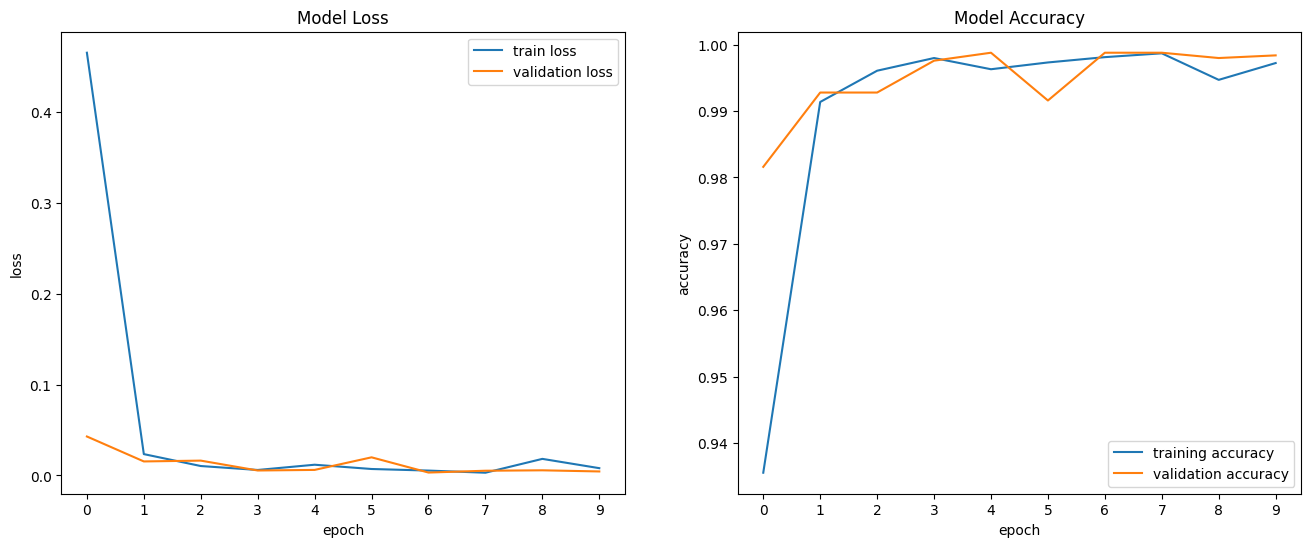

225/225 [==============================] - 31s 138ms/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.0043 - val_accuracy: 0.9984


In [ ]:
# model training

num_epochs = 10

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train, Y_train,
          batch_size=100, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [ ]:
model_1A = model
save_model_to_disk(model_1A, 'waveform_gender_model')

Saved model to waveform_gender_model.json and weights to waveform_gender_model.h5


In [14]:
!

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\lic9\.conda\envs\dlenv_20231114\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [ ]:

X = x
Y = y_num
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

In [ ]:
SAMPLING_RATE = 8000
CLASS_NUMS = 10;


def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    #origin_outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    #outputs = keras.layers.Reshape((2, 1))(origin_outputs)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


#model = build_model((SAMPLING_RATE // 2, 1), len(class_names))
model = build_model((SAMPLING_RATE , 1), CLASS_NUMS)


model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_55 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation_39 (Activation)  (None, 8000, 16)             0         ['conv1d_55[0][0]']           
                                                                                                  
 conv1d_56 (Conv1D)          (None, 8000, 16)             784       ['activation_39[0][0]']       
                                                                                            

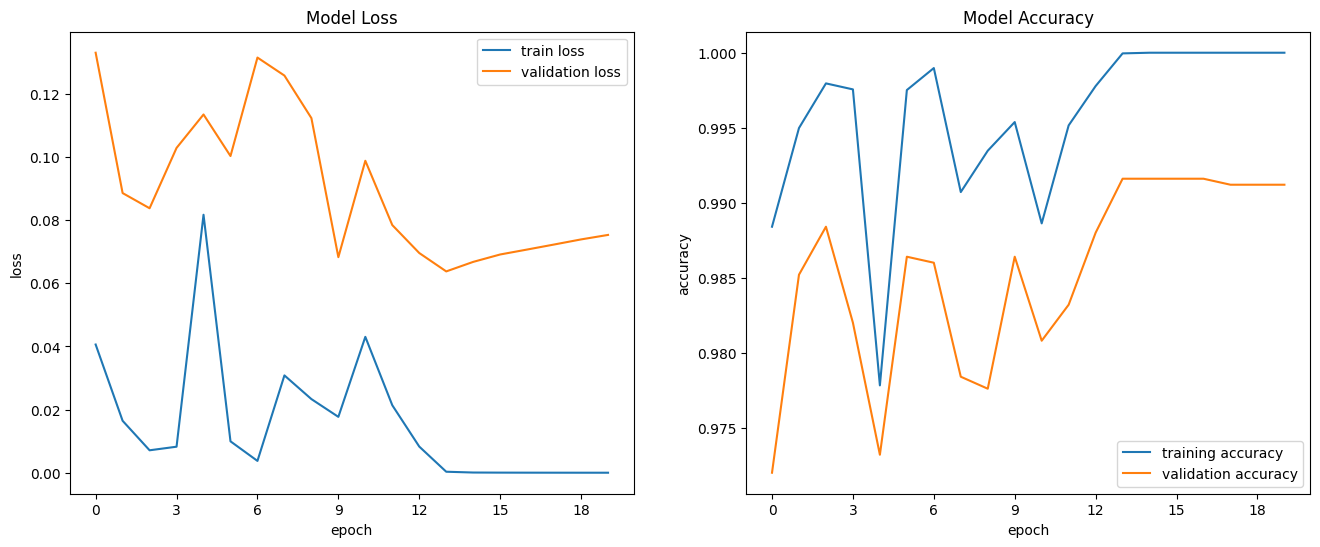

225/225 [==============================] - 32s 140ms/step - loss: 1.4359e-05 - accuracy: 1.0000 - val_loss: 0.0753 - val_accuracy: 0.9912


In [ ]:
# model training

num_epochs = 20

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train, Y_train,
          batch_size=100, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [ ]:
# Task 1B: Digit Classisation on Waveforms

# Construct your neural networks here

model_1B = model# Figure this out
save_model_to_disk(model_1B, 'waveform_digit_model')

In [9]:
# data pre process - transfer by stft

#f, t, Zxx = scipy.signal.stft(x, 8000, nperseg=455, noverlap=393, window='hann')
#Zxx_ = np.abs(Zxx[0:227, 2:-1])
#Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
# after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
#Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)



# n_mels = 128

# spectrogram_dataset = np.zeros((x.shape[0], n_mels, 128, 1))

# for i in range(x.shape[0]):
#   _, _, Zxx = scipy.signal.stft(x[i], 8000, nperseg=455, noverlap=393, window='hann')

#   mel_spectrogram = librosa.feature.melspectrogram(
#       y=None,
#       S=librosa.amplitude_to_db(np.abs(Zxx)),
#       sr=8000,
#       n_mels=n_mels
#   )


#   mel_spectrogram = mel_spectrogram[:, :128]
#   mel_spectrogram = np.reshape(mel_spectrogram, (n_mels, 128, 1))


#   spectrogram_dataset[i, :, :, :] = mel_spectrogram
n_mels = 128

spectrogram_dataset = np.zeros((x.shape[0], n_mels, 128))

for i in range(x.shape[0]):
  _, _, Zxx = scipy.signal.stft(x[i], 8000, nperseg=455, noverlap=393, window='hann')

  mel_spectrogram = librosa.feature.melspectrogram(
      y=None,
      S=librosa.amplitude_to_db(np.abs(Zxx)),
      sr=8000,
      n_mels=n_mels
  )


  mel_spectrogram = mel_spectrogram[:, :128]
  mel_spectrogram = np.reshape(mel_spectrogram, (n_mels, 128))


  spectrogram_dataset[i, :, :] = mel_spectrogram



In [12]:
f, t, Zxx = scipy.signal.stft(x[1], 8000, nperseg=455, noverlap=393, window='hann')
Zxx_ = np.abs(Zxx[0:227, 2:-1])
Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
# after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
Zxx_ = resize(Zxx_, (1, 128, 128))

In [45]:
spectrogram_dataset = np.zeros((x.shape[0], 128, 128))
for i in range(x.shape[0]):
  f, t, Zxx = scipy.signal.stft(x[i], 8000, nperseg=455, noverlap=393, window='hann')
  Zxx_ = np.abs(Zxx[0:227, 2:-1])
  Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
  # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
  Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
  Zxx_ = resize(Zxx_, (1,128, 128))
  spectrogram_dataset[i, :, :] = Zxx_

In [46]:
# check the result of pre processing
print("Array shape:", spectrogram_dataset.shape)

Array shape: (25000, 128, 128)


In [47]:
# save the stft result to drive for saving RAM resource
np.save('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy', spectrogram_dataset)

In [48]:
X = np.load('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy')

In [49]:
#X = spectrogram_dataset
Y = y_gender
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)




Array shape:
 (22500, 128, 128)
Array shape:
 (22500,)
Array shape:
 (2500, 128, 128)
Array shape:
 (2500,)


[   7.51096522   37.98076923   69.16208791  100.34340659  131.52472527
  162.70604396  193.88736264  225.06868132  256.25        287.43131868
  318.61263736  349.79395604  380.97527473  412.15659341  443.33791209
  474.51923077  505.70054945  536.88186813  568.06318681  599.24450549
  630.42582418  661.60714286  692.78846154  723.96978022  755.1510989
  786.33241758  817.51373626  848.69505495  879.87637363  911.05769231
  942.23901099  973.42032967 1004.60164835 1035.78296703 1066.96428571
 1098.1456044  1129.32692308 1160.50824176 1191.68956044 1222.87087912
 1254.0521978  1285.23351648 1316.41483516 1347.59615385 1378.77747253
 1409.95879121 1441.14010989 1472.32142857 1503.50274725 1534.68406593
 1565.86538462 1597.0467033  1628.22802198 1659.40934066 1690.59065934
 1721.77197802 1752.9532967  1784.13461538 1815.31593407 1846.49725275
 1877.67857143 1908.85989011 1940.04120879 1971.22252747 2002.40384615
 2033.58516484 2064.76648352 2095.9478022  2127.12912088 2158.31043956
 2189.4

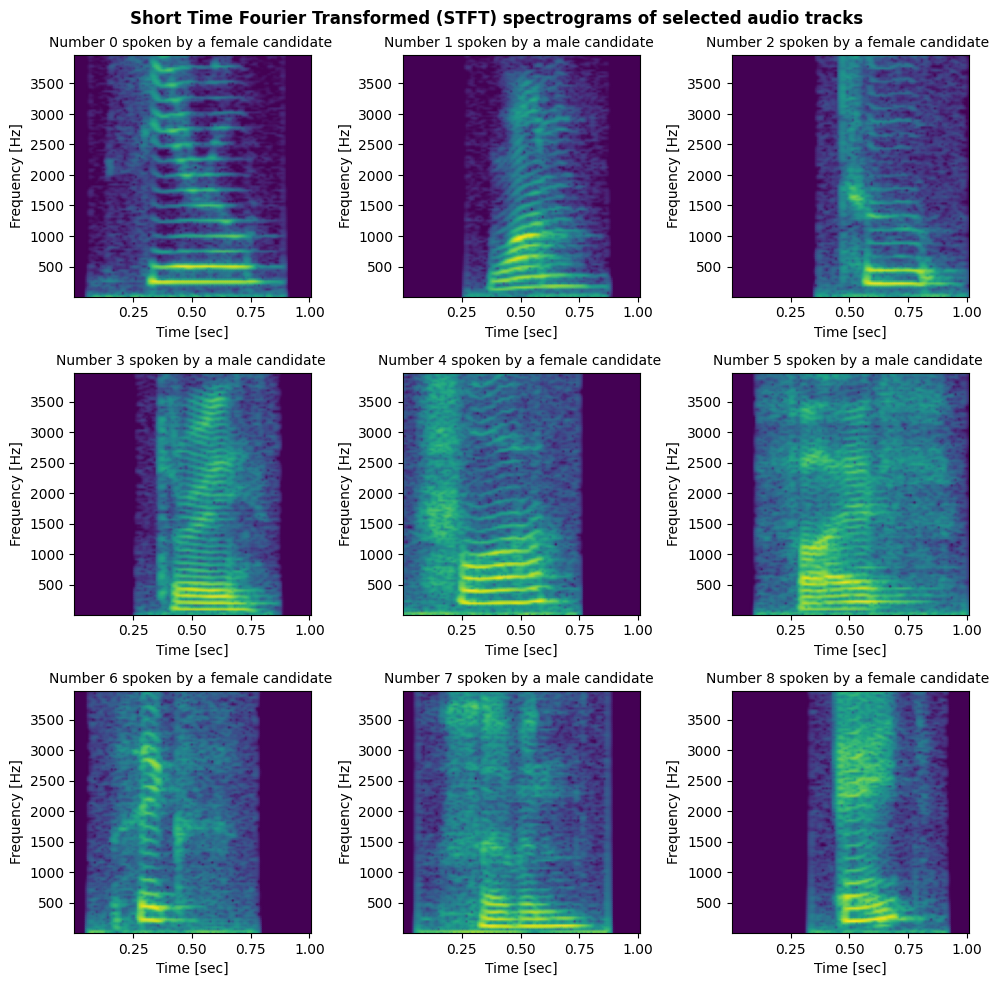

In [33]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # we want to show different genders in this preview, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'
    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when you try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    
    print(f_)
    print(t_)

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

0


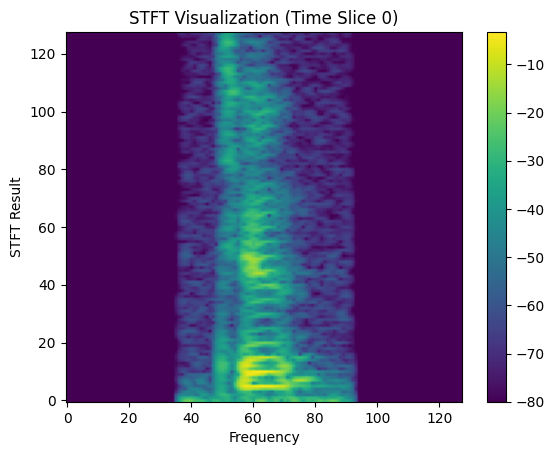

1


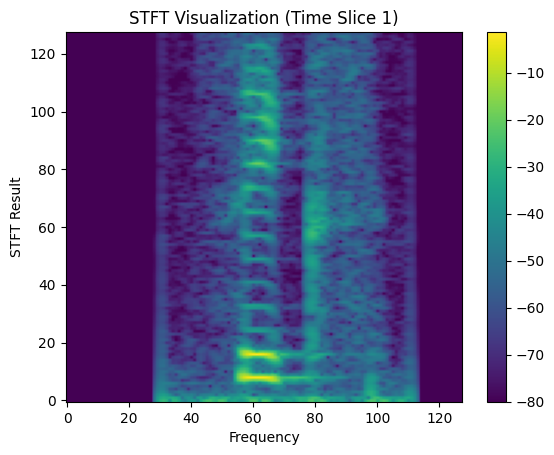

0


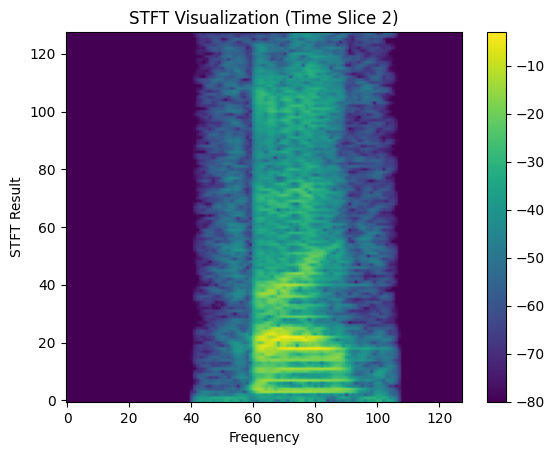

0


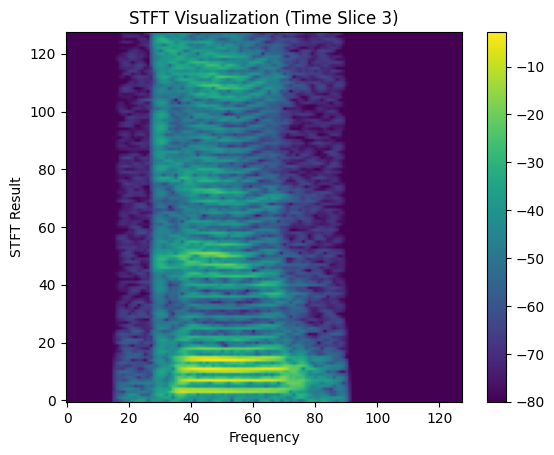

0


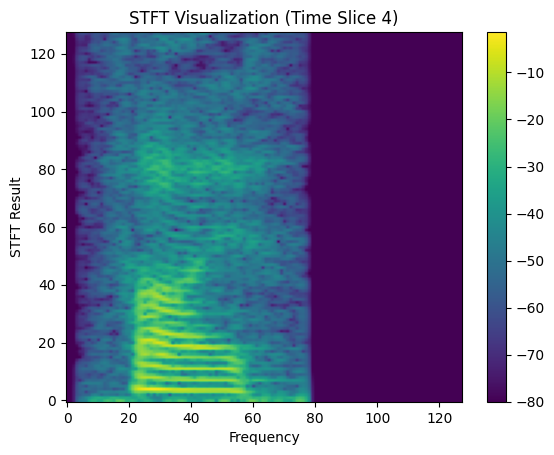

0


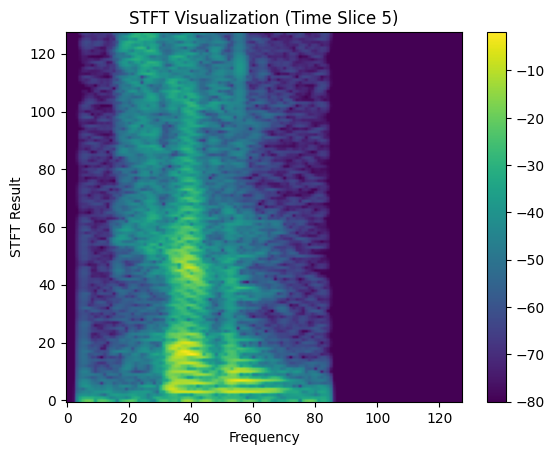

0


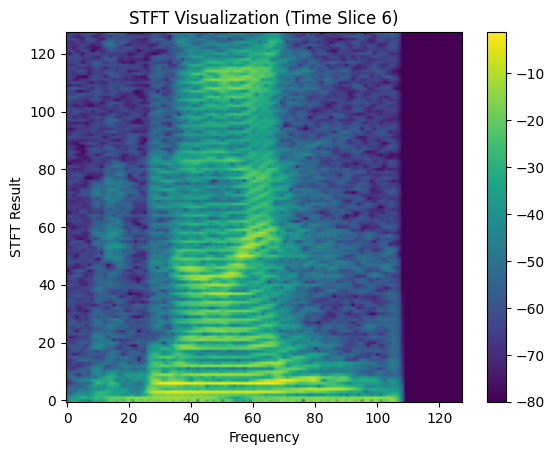

0


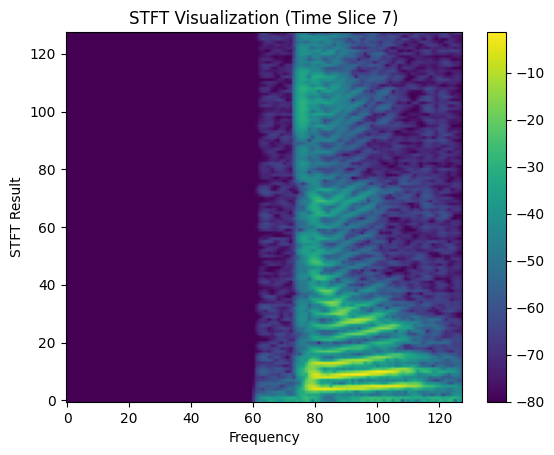

0


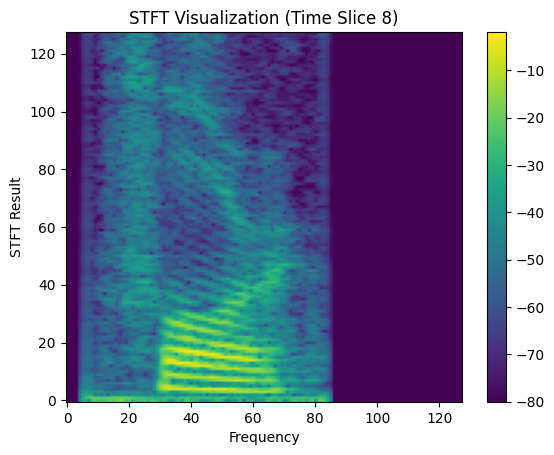

0


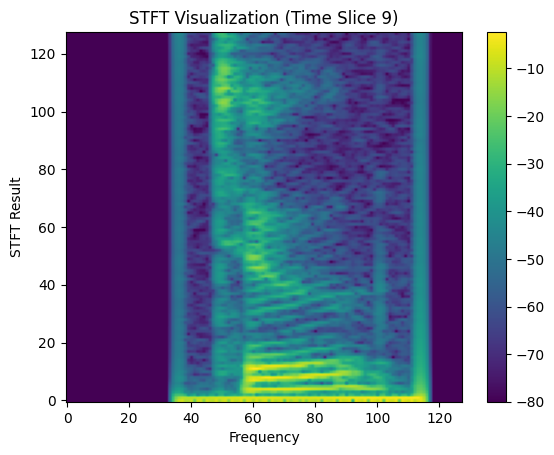

In [58]:
for time_slice in range(10):
    #time_slice = 200
    stft_data = X_train
    # Extract the 2D slice from the 4D data
    stft_slice = stft_data[time_slice, :, :]
    print(Y_train[time_slice])

    # Create a 2D plot
    plt.imshow(stft_slice, cmap='viridis', aspect='auto', origin='lower')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel('STFT Result')
    plt.title('STFT Visualization (Time Slice {})'.format(time_slice))

    # Show the colorbar for reference
    plt.colorbar()

    # Show the plot
    plt.show()

In [ ]:
# define CTC loss function

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [60]:
# Alex net
# define model



def build_model():
  inputs = keras.layers.Input(shape=(128, 128, 1))
  x = inputs
  x = keras.layers.Conv2D(96, (11,11), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((5,5), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(256, (5,5), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)

  x = keras.layers.Conv2D(384, (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(384, (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(256, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  x = keras.layers.Dense(256, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  x = keras.layers.Dense(128, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  output = keras.layers.Dense(2, activation='sigmoid', name="output")(x)

  # Create the model.
  model = keras.models.Model(inputs=inputs, outputs=output)
  opt = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

  # Setup the optimisation strategy.
  model.compile(optimizer="Adam",
                loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model
# optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]

# Get the model
model = build_model()

# changhong: for this scene, we dont need to tackle continuous voice , RNN is useless so dercease rnn_units

model.summary(line_length=110)

Model: "model_7"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_8 (InputLayer)                            [(None, 128, 128, 1)]                       0                
                                                                                                              
 conv2d_33 (Conv2D)                              (None, 128, 128, 96)                        11712            
                                                                                                              
 max_pooling2d_19 (MaxPooling2D)                 (None, 31, 31, 96)                          0                
                                                                                                              
 dropout_33 (Dropout)                            (None, 31, 31, 96)                          0 

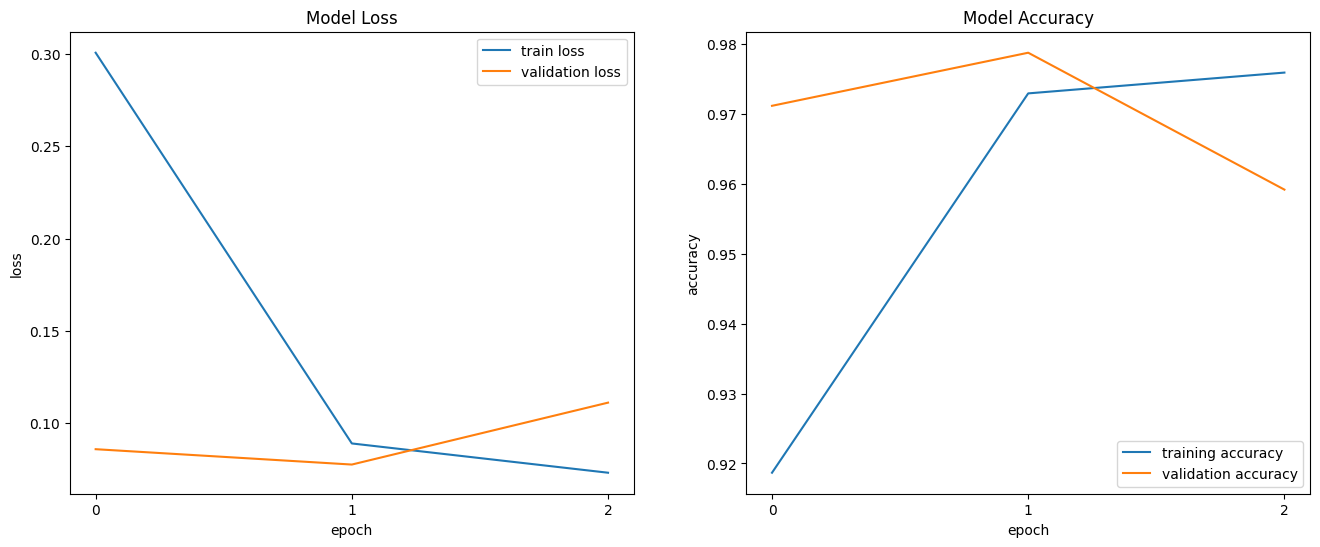

563/563 [==============================] - 18s 32ms/step - loss: 0.0731 - accuracy: 0.9760 - val_loss: 0.1111 - val_accuracy: 0.9592
Epoch 4/20
331/563 [================>.............] - ETA: 6s - loss: 0.0740 - accuracy: 0.9761

In [ ]:
# model training


num_epochs = 20

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
with tf.device('/GPU:1'):
    model.fit(X_train, Y_train,
          batch_size=40, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [6]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("NUM OF GPU = ", len(tf.config.experimental.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
NUM OF GPU =  1


In [ ]:
# Task 2A: Gender Classisation on Spectrograms
# first you'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct your neural networks here

model_2A = # Figure this out
save_model_to_disk(model_2A, 'spectrogram_gender_model')

In [ ]:
# Task 2B: Digit Classisation on Spectrograms
# first you'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct your neural networks here

model_2B = # Figure this out
save_model_to_disk(model_2B, 'spectrogram_digit_model')